In [51]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fifa19/data.csv
/kaggle/input/fifa-20-complete-player-dataset/players_15.csv
/kaggle/input/fifa-20-complete-player-dataset/players_16.csv
/kaggle/input/fifa-20-complete-player-dataset/players_17.csv
/kaggle/input/fifa-20-complete-player-dataset/players_18.csv
/kaggle/input/fifa-20-complete-player-dataset/players_19.csv
/kaggle/input/fifa-20-complete-player-dataset/teams_and_leagues.csv
/kaggle/input/fifa-20-complete-player-dataset/players_20.csv
/kaggle/input/fifa-world-cup/WorldCupPlayers.csv
/kaggle/input/fifa-world-cup/WorldCupMatches.csv
/kaggle/input/fifa-world-cup/WorldCups.csv


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from keras.utils import to_categorical
from keras.layers import LeakyReLU
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam , SGD , Adagrad , Adadelta , Adamax
from keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from numpy import mean
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import std

In [53]:
filename = "/kaggle/input/fifa19/data.csv"
df = pd.read_csv(filename)
filename2 = "/kaggle/input/fifa-world-cup/WorldCupMatches.csv"
matches = pd.read_csv(filename2)
filename3 = "/kaggle/input/fifa-world-cup/WorldCupPlayers.csv"
players = pd.read_csv(filename3)
filename4 = "/kaggle/input/fifa-world-cup/WorldCups.csv"
cups = pd.read_csv(filename4)
mat = matches.copy()
pla = players.copy()


In [54]:
cups = cups.drop(["Attendance", "Third", "Fourth","QualifiedTeams"],  axis=1)

In [55]:

from sklearn.utils import shuffle
matches = shuffle(matches)

In [56]:
matches = matches[matches["Year"]>1950]
matches.value_counts()

Year    Datetime              Stage                     Stadium                        City             Home Team Name  Home Team Goals  Away Team Goals  Away Team Name    Win conditions                         Attendance  Half-time Home Goals  Half-time Away Goals  Referee                   Assistant 1                  Assistant 2               RoundID   MatchID      Home Team Initials  Away Team Initials
2014.0  30 Jun 2014 - 13:00   Round of 16               Estadio Nacional               Brasilia         France          2.0              0.0              Nigeria                                                  67882.0     0.0                   0.0                   GEIGER Mark (USA)         HURD Sean (USA)              FLETCHER Joe (CAN)        255951.0  300186462.0  FRA                 NGA                   2
        12 Jul 2014 - 17:00   Play-off for third place  Estadio Nacional               Brasilia         Brazil          0.0              3.0              Netherlands          

In [57]:
results = (matches["Home Team Goals"] > matches["Away Team Goals"]).astype(int)
y = (matches["Home Team Goals"] == matches["Away Team Goals"]).astype(int)
for i in results.index:
    if(results[i]==0 and y[i]==1):
        results[i] = 2
    
print(results)
matches = matches.drop(["Referee", "Assistant 1","Assistant 2","Attendance", "Stadium", "Datetime", "RoundID", "MatchID","City", "Home Team Initials", "Away Team Initials", "Home Team Goals", "Away Team Goals", "Half-time Home Goals", "Half-time Away Goals"],axis=1)



339    2
844    0
337    1
653    0
721    1
      ..
279    1
125    1
798    1
505    1
389    0
Length: 777, dtype: int64


In [58]:
matches.head()

,Year,Stage,Home Team Name,Away Team Name,Win conditions
339,1982.0,Group 4,France,Czechoslovakia,
844,2014.0,Quarter-finals,France,Germany,
337,1982.0,Group 6,Brazil,New Zealand,
653,2006.0,Group E,USA,Czech Republic,
721,2010.0,Group G,Brazil,Korea DPR,


In [59]:
matches["Win conditions"] = matches["Win conditions"].replace(" ", 0)
matches[matches["Win conditions"] != 0] = 1
print(matches)

    

       Year           Stage Home Team Name  Away Team Name Win conditions
339  1982.0         Group 4         France  Czechoslovakia              0
844  2014.0  Quarter-finals         France         Germany              0
337  1982.0         Group 6         Brazil     New Zealand              0
653  2006.0         Group E            USA  Czech Republic              0
721  2010.0         Group G         Brazil       Korea DPR              0
..      ...             ...            ...             ...            ...
279  1978.0         Group 2         Poland         Tunisia              0
125  1958.0         Group 4   Soviet Union         England              0
798  2014.0         Group F      Argentina         IR Iran              0
505  1994.0     Round of 16         Brazil             USA              0
389  1986.0         Group B           Iraq          Mexico              0

[777 rows x 5 columns]


In [60]:
team_name= {}
index =0
for idx,row in matches.iterrows():
    name = row['Home Team Name']
    if(name not in team_name.keys()):
        team_name[name] = index
        index += 1
    name = row['Away Team Name']
    if(name not in team_name.keys()):
        team_name[name] = index
        index += 1
        
team_name

{'France': 0,
 'Czechoslovakia': 1,
 'Germany': 2,
 'Brazil': 3,
 'New Zealand': 4,
 'USA': 5,
 'Czech Republic': 6,
 'Korea DPR': 7,
 1: 8,
 'IR Iran': 9,
 'Nigeria': 10,
 'Argentina': 11,
 'Bulgaria': 12,
 'Russia': 13,
 'Tunisia': 14,
 'Germany FR': 15,
 'England': 16,
 'Switzerland': 17,
 'Croatia': 18,
 'Romania': 19,
 'Poland': 20,
 'Ecuador': 21,
 'Japan': 22,
 'Colombia': 23,
 'Yugoslavia': 24,
 'Iraq': 25,
 'Belgium': 26,
 'Sweden': 27,
 'Costa Rica': 28,
 'Mexico': 29,
 'Italy': 30,
 'Chile': 31,
 'Cameroon': 32,
 'Netherlands': 33,
 'Denmark': 34,
 'Saudi Arabia': 35,
 'Ukraine': 36,
 'Hungary': 37,
 'Northern Ireland': 38,
 'Uruguay': 39,
 'Korea Republic': 40,
 'Spain': 41,
 'Paraguay': 42,
 'rn">Republic of Ireland': 43,
 'Austria': 44,
 'Scotland': 45,
 'Algeria': 46,
 'Soviet Union': 47,
 'Bolivia': 48,
 'Israel': 49,
 'Serbia': 50,
 'Portugal': 51,
 'Norway': 52,
 'South Africa': 53,
 'Togo': 54,
 'Angola': 55,
 'Egypt': 56,
 'Morocco': 57,
 'Haiti': 58,
 'Peru': 59,
 

In [61]:
stage= {}
index =0
for idx,row in matches.iterrows():
    name = row['Stage']
    if(name not in stage.keys()):
        stage[name] = index
        index += 1
    name = row['Stage']
    if(name not in stage.keys()):
        stage[name] = index
        index += 1
        
stage

{'Group 4': 0,
 'Quarter-finals': 1,
 'Group 6': 2,
 'Group E': 3,
 'Group G': 4,
 1: 5,
 'Group F': 6,
 'Group D': 7,
 'Group H': 8,
 'Group 2': 9,
 'Semi-finals': 10,
 'Round of 16': 11,
 'Group A': 12,
 'Group 3': 13,
 'Group C': 14,
 'Group B': 15,
 'Match for third place': 16,
 'Group 1': 17,
 'Final': 18,
 'Group 5': 19,
 'Third place': 20,
 'Play-off for third place': 21}

In [62]:
match_id_away = matches["Away Team Name"].replace(team_name)
matches["Away Team Name"] = match_id_away
match_id_home = matches["Home Team Name"].replace(team_name)
matches["Home Team Name"] = match_id_home
match_id_stage = matches["Stage"].replace(stage)
matches["Stage"] = match_id_stage
matches.head()


,Year,Stage,Home Team Name,Away Team Name,Win conditions
339,1982.0,0,0,1,0
844,2014.0,1,0,2,0
337,1982.0,2,3,4,0
653,2006.0,3,5,6,0
721,2010.0,4,3,7,0


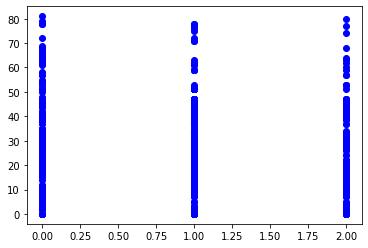

In [63]:
plt.scatter(results, matches["Home Team Name"], c ="blue")

In [64]:
matches["Win conditions"] = matches["Win conditions"].astype(int)

In [65]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 777 entries, 339 to 389
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Year            777 non-null    float64
 1   Stage           777 non-null    int64  
 2   Home Team Name  777 non-null    int64  
 3   Away Team Name  777 non-null    int64  
 4   Win conditions  777 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 52.6 KB


In [66]:
X_train, X_test, y_train, y_test = train_test_split(matches, results)

In [67]:
rfc = RandomForestClassifier(class_weight = 'balanced',n_estimators = 120, max_depth = 7)
#params = {'n_estimators' : [80, 90, 100, 110, 120],
#          'max_depth' : [3, 4, 5, 6, 7]
#          }
#clf = GridSearchCV(rfc, params, scoring = 'accuracy')

print('Training model using Cross validation.....')
rfc.fit(X_train, y_train)
print(rfc.score(X_test,y_test))

#print('The Best score was found to be {:.3f}'.format(search.best_score_))
#print('The Best params were {}'.format(search.best_params_))

Training model using Cross validation.....
0.48717948717948717


In [71]:
xgb = GradientBoostingClassifier()
params = {'n_estimators' : [80, 90, 100, 110, 120],
          'max_depth' : [3, 4, 5, 6, 7]
          }
clf = GridSearchCV(xgb, params, scoring = 'accuracy')

print('Training model using Cross validation.....')
search = clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))

print('The Best score was found to be {:.3f}'.format(search.best_score_))
print('The Best params were {}'.format(search.best_params_))

Training model using Cross validation.....
0.5333333333333333
The Best score was found to be 0.594
The Best params were {'max_depth': 3, 'n_estimators': 110}


In [68]:
model = XGBClassifier()
model.fit(X_train, y_train)
print( model.score(X_test, y_test))

[23:30:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5128205128205128


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [110]:
print(rfc.predict_proba(X_test), results)

[[0.33610091 0.40219785 0.26170125]
 [0.34147076 0.37208429 0.28644495]
 [0.48068052 0.34503097 0.17428852]
 [0.46319003 0.47150585 0.06530413]
 [0.87194403 0.06284112 0.06521485]
 [0.56995809 0.40715478 0.02288712]
 [0.52337532 0.34360903 0.13301565]
 [0.53270299 0.25491106 0.21238595]
 [0.39192429 0.34930054 0.25877517]
 [0.31587565 0.46917583 0.21494852]
 [0.48512256 0.28527688 0.22960056]
 [0.21507757 0.42225212 0.3626703 ]
 [0.23840146 0.28374892 0.47784961]
 [0.3480895  0.38628713 0.26562337]
 [0.20475004 0.45550951 0.33974045]
 [0.6530209  0.02124602 0.32573308]
 [0.10246533 0.24477554 0.65275912]
 [0.28345324 0.44105802 0.27548874]
 [0.37065486 0.44377326 0.18557189]
 [0.20513075 0.46238654 0.33248271]
 [0.18565533 0.43335805 0.38098662]
 [0.75281483 0.21310822 0.03407695]
 [0.16935064 0.74441295 0.08623641]
 [0.13081839 0.75003517 0.11914644]
 [0.5268362  0.28977797 0.18338583]
 [0.5705191  0.02124602 0.40823487]
 [0.10246533 0.24477554 0.65275912]
 [0.12979993 0.57225477 0.29

In [ ]:
import pandas_profiling
matches.profile_report()